In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import xarray as xr
from scipy.interpolate import interp1d

In [2]:
class DataCleaner:
    
    def __init__(self, ds):
        
        self.ds = ds
        
    def clean_entire_nan_columns_non_zero_thick(self, var, thick_var, replace_with = 0.0):
    
        # For interpolated variables, thick_var has to be some interpolated thickness, otherwise shapes won't match
        
        variable = self.ds.variables[var]
        thick = self.ds.variables[thick_var]
        
        shape_z, shape_x, shape_y = variable.shape

        sum_nan_columns = np.sum(np.isnan(variable), axis = 0)
        
        for i in range(shape_x):
            for j in range(shape_y):
                if sum_nan_columns[i,j] == shape_z and thick[i,j] == 0.0:
                    variable[:,i,j] = replace_with
                    
        self.ds.variables[var][:] = variable
        
        if 'modifications' in self.ds[var].attrs:
            
            self.ds[var].attrs['modifications'] = self.ds[var].attrs['modifications'] + \
                                                                ', Clear all NaN columns'
        else:
            
            self.ds[var].attrs['modifications'] = 'Clear all NaN columns'
                   
    def nan_stats(self, var, thick_var):
        
        # For interpolated variables, thick_var has to be some interpolated thickness, otherwise shapes won't match
        
        variable = self.ds.variables[var]
        shape_z, shape_x, shape_y = variable.shape
        num_nan_columns = 0
        flag_nan_columns = np.zeros((shape_x, shape_y), dtype = int)
        
        sum_nan_columns = np.sum(np.isnan(variable), axis = 0)
        flag_nan_columns = sum_nan_columns == shape_z
        num_nan_columns = np.sum(flag_nan_columns)
        
        flag_non_zero_thick = self.ds.variables[thick_var] > 0.0

        flag_nan_columns_nonzero_thick = np.logical_and(flag_non_zero_thick, flag_nan_columns)
        num_nan_columns_nonzero_thick = np.sum(flag_nan_columns_nonzero_thick)
        
        num_nan_z_levels = np.sum(np.isnan(variable), axis = (1,2))
        
        flag_nan = np.isnan(variable)
        
        ### Pad a with 0 at both sides for edge cases when a starts or ends with 1
        ### See answer by Psidom - 
        ### https://stackoverflow.com/questions/54446907/how-to-calculate-numbers-of-uninterrupted-repeats-in-an-array-in-python/54447096#54447096

        ### In our case, pad only in the z-dimension
        temp = np.pad(flag_nan, pad_width=((1, 1), (0, 0), (0, 0)), mode='constant')
        flag_num_nan_patches_columns = np.sum(np.logical_xor(temp[1:], temp[:-1]) == True, axis = 0) / 2
        flag_num_nan_patches_columns = flag_num_nan_patches_columns.astype(int)
        statsDict = {}
        flagsDict = {}
        
        statsDict['Total NaNs'] = np.count_nonzero(np.isnan(variable))
        statsDict['Total NaN columns'] = num_nan_columns
        statsDict['Total NaN columns with non-zero ice thickness'] = num_nan_columns_nonzero_thick
        statsDict['Total NaN on different z-levels'] = num_nan_z_levels
        
        flagsDict['Flag for all NaN columns'] = flag_nan_columns
        flagsDict['Total NaN in each column'] = sum_nan_columns
        flagsDict['Flag for all NaN columns, non-zero thick'] = flag_nan_columns_nonzero_thick
        flagsDict['Flag for num of contiguous NaN patches in cols'] = flag_num_nan_patches_columns
        
        return statsDict, flagsDict
    
    def clean_middle_nans(self, var, kind = 'linear'):
        
        def middle_clean_column(z, 
                                #z_interp,
                                var_column, kind = 'linear'):

            start = np.where(~np.isnan(var_column))[0][0]
            end = np.where(~np.isnan(var_column))[0][-1]

            z_middle = z[start:end+1]

            var_column_copy = np.copy(var_column)

            var_column_middle = var_column_copy[start:end+1]

            #z_interp_middle = z_interp[z_interp >= z_middle[0]]
            #z_interp_middle = z_interp_middle[z_interp_middle <= z_middle[-1]]

            flag_not_nan_middle = ~np.isnan(var_column_middle)

            f = interp1d(z_middle[flag_not_nan_middle], var_column_middle[flag_not_nan_middle], kind = kind)

            var_column_copy[start:end+1] = f(z_middle) # f(z_interp_middle)

            return var_column_copy
        
        variable_values = self.ds.variables[var].values
        
        shape_z, shape_x, shape_y = variable_values.shape
        
        var_middle_clean = var + '_middle_clean'
        
        for i in range(shape_x):
            for j in range(shape_y):
                
                if np.sum(np.isnan(variable_values[:,i,j])) in [0, shape_z - 1, shape_z]:
                    pass
                else:
                    variable_values[:,i,j] = middle_clean_column(np.arange(shape_z), variable_values[:,i,j])
    
        self.ds.variables[var][:] = variable_values
    
        if 'modifications' in self.ds[var].attrs:
            
            self.ds[var].attrs['modifications'] = self.ds[var].attrs['modifications'] + \
                                                                f', Clean middle columns using {kind} interpolation'
        else:
            
            self.ds[var].attrs['modifications'] = f'Clean middle columns using {kind} interpolation'
        

In [40]:
class DataInterpolator(DataCleaner):
    
    def __init__(self, ds, 
                 model_x, model_y, model_KCMAX, model_exp_a = 2.0,
                 method = 'nearest_neighbor'):
        
        super().__init__(ds)
        
        self.ds = ds
        
        self.model_x = model_x
        self.model_y = model_y
        self.model_KCMAX = model_KCMAX
        self.model_exp_a = model_exp_a
        self.method = method
        
        if self.method != 'nearest_neighbor':
            raise NotImplementedError("Only nearest_neighbor interpolation is available.")

    def expand_dims(self):
        
        self.ds_expanded = xr.Dataset()
        
        Dict = {}
        Dict['number of model grid points in x-direction'] = self.model_x.shape[0]
        Dict['number of model grid points in y-direction'] = self.model_y.shape[0]
        Dict['number of vertical model layers'] = self.model_KCMAX + 1
        
        self.ds_expanded = self.ds_expanded.expand_dims(Dict)

    def add_model_variables(self):
        
        x_model_mesh, y_model_mesh = np.meshgrid(self.model_x, self.model_y)
        
        self.ds_expanded['x_model'] = (['number of model grid points in x-direction', 
                               'number of model grid points in y-direction'], x_model_mesh.T)
        self.ds_expanded['y_model'] = (['number of model grid points in x-direction', 
                               'number of model grid points in y-direction'], y_model_mesh.T)
        self.ds_expanded['zeta_c_model'] = (['number of vertical model layers'], np.linspace(0.,1.,self.model_KCMAX+1))
        
        zeta_c_model_exp = (np.exp(self.model_exp_a*self.ds_expanded['zeta_c_model'])-1) \
                          /(np.exp(self.model_exp_a)-1)
        
        self.ds_expanded['zeta_c_exp_model'] = (['number of vertical model layers'], zeta_c_model_exp.values)
        self.ds_expanded['zeta_c_exp_model'].attrs['Exp parameter'] = self.model_exp_a
        
    def unfreeze_ds(self):
        ### ds.dim will show that the dataset is frozen and we cannot add more dimensions
        ### Instead we will create a new dataset
        
        ds_unfrozen = self.ds_expanded.copy()
        
        ds_unfrozen.attrs = self.ds.attrs

        for key, value in self.ds.variables.items():
            ds_unfrozen[key] = value

        self.ds = ds_unfrozen.copy() 
        
    def add_top_layer(self, var):
        
        ### This operation only makes sense for original variables
        ### You should add top layer and then interpolate in the vertical
        
        variable = self.ds.variables[var]
        
        shape_z, shape_x, shape_y = variable.shape
        
        var_new = var + '_TopLayerAdded'
        
        variable_new = np.zeros((shape_z+1, shape_x, shape_y), dtype = float)
        variable_new[1:] = np.copy(variable.values)
        
        self.ds[var_new] = (['number of vertical layers with top layer added', 
                                'number of grid points in x-direction', 
                                'number of grid points in y-direction'], 
                               variable_new)      

        self.ds[var_new].attrs['Base variable'] = var
        
        if 'modifications' in self.ds[var].attrs:
            
            self.ds[var_new].attrs['modifications'] = self.ds[var].attrs['modifications'] + \
                                                                ', Top layer added'
        else:
            
            self.ds[var_new].attrs['modifications'] = 'Top layer added'
            
    def NN_2D(self):
        
        self.data_x_closest_indices = np.zeros(self.model_x.shape, dtype = int)
        self.data_y_closest_indices = np.zeros(self.model_y.shape, dtype = int)
    
        for i in range(self.model_x.shape[0]):
            
            self.data_x_closest_indices[i] = np.abs(self.model_x[i] - self.ds['x'][:,0]).argmin()
        
        for j in range(self.model_y.shape[0]):

            self.data_y_closest_indices[j] = np.abs(self.model_y[j] - self.ds['y'][0,:]).argmin()

        self.ds['thick_2D_interp'] = (['number of model grid points in x-direction', 
                                       'number of model grid points in y-direction'], 
                                      self.ds.variables['thick'].values[np.ix_(self.data_x_closest_indices, self.data_y_closest_indices)])

        self.ds['thick_2D_interp'].attrs['Base variable'] = 'thick'

        if 'modifications' in self.ds['thick'].attrs:
            
            self.ds['thick_2D_interp'].attrs['modifications'] = self.ds['thick'].attrs['modifications'] + \
                                                                ', 2D Nearest Neighbor Interpolation'
        else:
            
            self.ds['thick_2D_interp'].attrs['modifications'] = '2D Nearest Neighbor Interpolation'
        
    def NN_2D_var(self, var):
        
        variable = self.ds.variables[var]
        
        shape_z, shape_x, shape_y = variable.shape
        
        var_interp = var + '_2D_interp'
        
        variable_interp = variable.values[np.ix_(range(shape_z), self.data_x_closest_indices, self.data_y_closest_indices)] 
        
        self.ds[var_interp] = (['number of vertical layers with top layer added', 
                                'number of model grid points in x-direction', 
                                'number of model grid points in y-direction'], 
                               variable_interp)
        
        self.ds[var_interp].attrs['Base variable'] = var
        
        if 'modifications' in self.ds[var].attrs:
            
            self.ds[var_interp].attrs['modifications'] = self.ds[var].attrs['modifications'] + \
                                                                ', 2D Nearest Neighbor Interpolation'
        else:
            
            self.ds[var_interp].attrs['modifications'] = '2D Nearest Neighbor Interpolation'
            
    def z_interpolation_middle_columns(self, var, kind = 'linear'):
        
        ### Assumed that the middle of the columns have no NaNs

        def interp_one_column_middle(z, z_interp, var_column, kind = 'linear'):

            var_column_interp = np.empty(len(z_interp))
            var_column_interp[:] = np.NaN
            
            start = np.where(~np.isnan(var_column))[0][0]
            end = np.where(~np.isnan(var_column))[0][-1]

            z_middle = z[start:end+1]

            var_column_middle = var_column[start:end+1]

            z_interp_middle = z_interp[z_interp >= z_middle[0]]
            start_interp = len(z_interp) - len(z_interp_middle)
            z_interp_middle = z_interp_middle[z_interp_middle <= z_middle[-1]]
            end_interp = len(z_interp_middle) + start_interp - 1

            f = interp1d(z_middle, var_column_middle, kind = kind)

            var_column_interp[start_interp:end_interp+1] = f(z_interp_middle)

            return var_column_interp
        
        variable_values = self.ds.variables[var].values
        
        shape_z, shape_x, shape_y = variable_values.shape
        
        var_interp = var + f'_z_interp_{kind}'
        
        variable_interp_values = np.empty((self.model_KCMAX + 1, shape_x, shape_y), dtype = float)
        variable_interp_values[:] = np.NaN
        
        zeta_c_data = np.linspace(0., 1., len(self.ds['number of vertical layers with top layer added']))
        zeta_c_model = self.ds['zeta_c_exp_model'].values
        
        for i in range(shape_x):
            for j in range(shape_y):
                
                if np.sum(np.isnan(variable_values[:,i,j])) in [shape_z - 1, shape_z]:
                    pass
                else:
                    variable_interp_values[:,i,j] = interp_one_column_middle(zeta_c_data,
                                                                            zeta_c_model, 
                                                                            variable_values[:,i,j], 
                                                                            kind = kind)
        
        self.ds[var_interp] = (['number of vertical model layers', 
                                'number of model grid points in x-direction', 
                                'number of model grid points in y-direction'], 
                                variable_interp_values)
        
        if 'modifications' in self.ds[var].attrs:
            
            self.ds[var_interp].attrs['modifications'] = self.ds[var].attrs['modifications'] + \
                                                                f', z {kind} interpolation'
        else:
            
            self.ds[var_interp].attrs['modifications'] = f'z {kind} interpolation'
        

In [41]:
### Reading a netcdf file
ds = xr.open_dataset('RRRAG4_Greenland_1993_2013_01_age_grid.nc')

In [42]:
ds

<xarray.Dataset>
Dimensions:           (number of isochrones: 4, number of grid points in x-direction: 1479, number of grid points in y-direction: 2675, number of vertical layers: 25)
Dimensions without coordinates: number of isochrones, number of grid points in x-direction, number of grid points in y-direction, number of vertical layers
Data variables:
    depth_iso         (number of isochrones, number of grid points in x-direction, number of grid points in y-direction) float64 ...
    depth_iso_uncert  (number of isochrones, number of grid points in x-direction, number of grid points in y-direction) float64 ...
    age_norm          (number of vertical layers, number of grid points in x-direction, number of grid points in y-direction) float64 ...
    age_norm_uncert   (number of vertical layers, number of grid points in x-direction, number of grid points in y-direction) float64 ...
    x                 (number of grid points in x-direction, number of grid points in y-direction) float64 ...
    y                 (number of grid points in x-direction, number of grid points in y-direction) float64 ...
    age_iso           (number of isochrones) float64 ...
    num_age_iso       float64 ...
    depth_norm        (number of vertical layers) float64 ...
    num_depth_norm    float64 ...
    thick             (number of grid points in x-direction, number of grid points in y-direction) float64 ...
Attributes:
    title:               Gridded age structure of the Greenland Ice Sheet
    original file name:  Greenland_age_grid.nc
    version:             1.2
    citation:            MacGregor, J.A., M.A. Fahnestock, G.A. Catania, J.D....
    date generated:      01-Apr-2015 08:59:30
    point of contact:    Joseph MacGregor, joemac@ig.utexas.edu
    grid projection:     EPSG:3413

In [43]:
x_model_10km = np.arange(-72.,97.,1.)*10
y_model_10km = np.arange(-345.,-56.,1.)*10
KCMAX = 80

In [63]:
DI = DataInterpolator(ds, x_model_10km, y_model_10km, KCMAX)
DI.expand_dims()
DI.add_model_variables()
DI.unfreeze_ds()
DI.add_top_layer('age_norm')
DI.NN_2D()
DI.NN_2D_var('age_norm_TopLayerAdded')
DI.clean_middle_nans('age_norm_TopLayerAdded_2D_interp', kind = 'linear')
DI.z_interpolation_middle_columns('age_norm_TopLayerAdded_2D_interp', kind = 'linear')

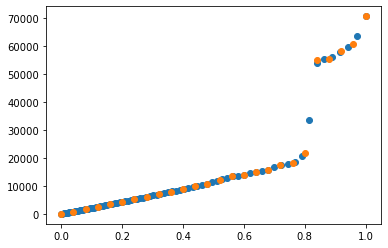

In [64]:
plt.scatter(DI.ds['zeta_c_exp_model'], DI.ds['age_norm_TopLayerAdded_2D_interp_z_interp_linear'][:,100,180])
plt.scatter(np.linspace(0., 1., len(DI.ds['number of vertical layers with top layer added'])),DI.ds['age_norm_TopLayerAdded_2D_interp'][:,100,180])

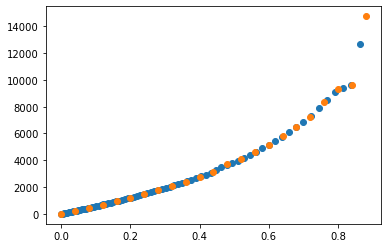

In [65]:
plt.scatter(DI.ds['zeta_c_exp_model'], DI.ds['age_norm_TopLayerAdded_2D_interp_z_interp_linear'][:,75,100])
plt.scatter(np.linspace(0., 1., len(DI.ds['number of vertical layers with top layer added'])),DI.ds['age_norm_TopLayerAdded_2D_interp'][:,75,100])

In [56]:
stats, flags = DI.nan_stats('age_norm_TopLayerAdded_2D_interp_z_interp_linear', 'thick_2D_interp')

In [57]:
stats

{'Total NaNs': 2986966,
 'Total NaN columns': <xarray.Variable ()>
 array(36192),
 'Total NaN columns with non-zero ice thickness': <xarray.Variable ()>
 array(5401),
 'Total NaN on different z-levels': <xarray.Variable (number of vertical model layers: 81)>
 array([36192, 36192, 36192, 36192, 36192, 36192, 36192, 36192, 36192,
        36192, 36192, 36192, 36192, 36192, 36192, 36192, 36192, 36192,
        36192, 36192, 36192, 36192, 36192, 36192, 36192, 36192, 36192,
        36192, 36192, 36194, 36194, 36194, 36194, 36194, 36194, 36194,
        36194, 36194, 36194, 36194, 36194, 36194, 36211, 36211, 36211,
        36213, 36213, 36213, 36219, 36219, 36219, 36250, 36250, 36250,
        36282, 36282, 36282, 36308, 36308, 36315, 36315, 36337, 36337,
        36337, 36377, 36377, 36403, 36403, 36492, 36651, 36651, 36957,
        36957, 37761, 37761, 39520, 42606, 42606, 44948, 47312, 47312])}

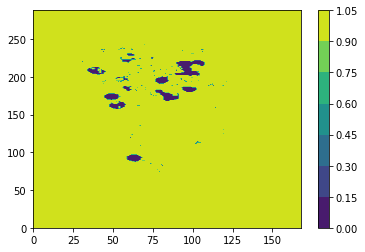

In [62]:
plt.contourf(flags['Flag for num of contiguous NaN patches in cols'].T)
plt.colorbar()

In [68]:
DI.ds

<xarray.Dataset>
Dimensions:                                           (number of model grid points in x-direction: 169, number of model grid points in y-direction: 289, number of vertical model layers: 81, number of isochrones: 4, number of grid points in x-direction: 1479, number of grid points in y-direction: 2675, number of vertical layers: 25, number of vertical layers with top layer added: 26)
Dimensions without coordinates: number of model grid points in x-direction, number of model grid points in y-direction, number of vertical model layers, number of isochrones, number of grid points in x-direction, number of grid points in y-direction, number of vertical layers, number of vertical layers with top layer added
Data variables: (12/19)
    x_model                                           (number of model grid points in x-direction, number of model grid points in y-direction) float64 ...
    y_model                                           (number of model grid points in x-direction, number of model grid points in y-direction) float64 ...
    zeta_c_model                                      (number of vertical model layers) float64 ...
    zeta_c_exp_model                                  (number of vertical model layers) float64 ...
    depth_iso                                         (number of isochrones, number of grid points in x-direction, number of grid points in y-direction) float64 ...
    depth_iso_uncert                                  (number of isochrones, number of grid points in x-direction, number of grid points in y-direction) float64 ...
    ...                                                ...
    num_depth_norm                                    float64 25.0
    thick                                             (number of grid points in x-direction, number of grid points in y-direction) float64 ...
    age_norm_TopLayerAdded                            (number of vertical layers with top layer added, number of grid points in x-direction, number of grid points in y-direction) float64 ...
    thick_2D_interp                                   (number of model grid points in x-direction, number of model grid points in y-direction) float64 ...
    age_norm_TopLayerAdded_2D_interp                  (number of vertical layers with top layer added, number of model grid points in x-direction, number of model grid points in y-direction) float64 ...
    age_norm_TopLayerAdded_2D_interp_z_interp_linear  (number of vertical model layers, number of model grid points in x-direction, number of model grid points in y-direction) float64 ...
Attributes:
    title:               Gridded age structure of the Greenland Ice Sheet
    original file name:  Greenland_age_grid.nc
    version:             1.2
    citation:            MacGregor, J.A., M.A. Fahnestock, G.A. Catania, J.D....
    date generated:      01-Apr-2015 08:59:30
    point of contact:    Joseph MacGregor, joemac@ig.utexas.edu
    grid projection:     EPSG:3413

In [ ]:
print(ds.__dict__)

In [ ]:
### Look at what dimensions are available
for dim in ds.dimensions.values():
    print(dim)

In [ ]:
### Look at what variables are available
### Use vars(var) to see __dict__ attribute for the object
### Use dir(var) to get all class attributes, one such attribute is _name
for var in ds.variables.values():
     print(var._name)

In [ ]:
ds.variables['age_iso'], ds.variables['num_age_iso']

In [ ]:
np.max(ds.variables['age_norm'][:]), np.min(ds.variables['age_norm'][:])

In [ ]:
np.max(ds.variables['age_norm_uncert'][:]), np.min(ds.variables['age_norm_uncert'][:])

In [ ]:
ds.variables['age_norm'][:,700,1300]

In [ ]:
ds.variables['age_norm_uncert'][:,700,1300]

In [ ]:
ds.variables['num_depth_norm'], ds.variables['depth_norm']

In [ ]:
ds.variables['thick']

In [ ]:
ds.variables['age_norm'], ds.variables['age_norm_uncert']

In [ ]:
%matplotlib inline
### Plot age
age_layer_number = 0
x = ds.variables['x'][:][:,0]
y = ds.variables['y'][:][0,:]
age = ds.variables['age_norm'][:][age_layer_number,:,:]

#plt.rcParams['figure.figsize'] = [15, 15]
plt.contourf(x,y,age.T)
plt.colorbar()
plt.title("Age contour on a horizontal slice number " + str(age_layer_number))
plt.show()

In [ ]:
### Depth of an iscohrone provided in the data
isochrone_number = 0
x = ds.variables['x'][:][:,0]
y = ds.variables['y'][:][0,:]
depth_iso = ds.variables['depth_iso'][:][isochrone_number,:,:]
age_iso = ds.variables['age_iso'][:][isochrone_number]

plt.contourf(x,y,depth_iso.T)
plt.colorbar()
plt.title("Depth of an isochrone number " + str(isochrone_number) + " of age " + str(age_iso))
plt.show()

In [ ]:
### Depth uncertainty of an iscohrone provided in the data
x = ds.variables['x'][:][:,0]
y = ds.variables['y'][:][0,:]
depth_iso_uncert = ds.variables['depth_iso_uncert'][:][isochrone_number,:,:]

plt.contourf(x,y,depth_iso_uncert.T)
plt.colorbar()
plt.title("Depth uncertainty of an isochrone number " + str(isochrone_number) + " of age " + str(age_iso))
plt.show()

In [ ]:
x = ds.variables['x'][:][:,0]
y = ds.variables['y'][:][0,:]
h = ds.variables['thick'][:][:,:]

plt.contourf(x,y,h.T)
plt.colorbar()
plt.title("Ice thickness")
plt.show()

In [ ]:
### Reading a netcdf file

df = nc.Dataset('v5_grl20_ss25ka0003.nc')

zb = np.asarray(df.variables['zb'])

In [ ]:
from scipy.spatial import distance

def closest_point(modelpoint, datapoints):
    closest_index = distance.cdist([modelpoint], datapoints).argmin()
    return datapoints[closest_index], closest_index

In [ ]:
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
polygon = Polygon([(0, -3250000), (100000,-3250000), (250000, -2900000), (800000,-2200000), (550000,-1000000), (200000, -700000),(0, -720000),(-300000, -900000),(-550000, -1200000), (-250000, -2500000), (-280000, -2900000), (-200000, -3100000)])

In [ ]:
def get_nearest_index(component, grid_component, level = 1):
    indices = []
    ii = np.argmin(np.abs(component - grid_component))

    if ii == 0 and component < grid_component[0]:

        indices.append(0)
    elif ii == len(grid_component) - 1 and component > grid_component[-1]:

        indices.append(len(grid_component) - 1)
        
    elif ii > len(grid_component) - 1 - level:

        for j in range(-level, 1):
            indices.append(ii + j)
        for j in range(ii+1, len(grid_component)):
            indices.append(j)
        
    elif ii < level:

        for j in range(ii):
            indices.append(j)
        for j in range(level+1):
            indices.append(ii + j)
            
    else:
        
        for j in range(-level, level+1):
            indices.append(ii + j)      
    
    return indices

def nearest_neighbor_interpolation_one_point(point, x_datagrid, y_datagrid, h_datagrid, field):
    point_polygon_datastructure = Point(point[2], point[1])

    if polygon.contains(point_polygon_datastructure):
        
        x_indexes = get_nearest_index(point[2], x_datagrid)
        y_indexes = get_nearest_index(point[1], y_datagrid)

        list_of_points_to_check = []
        values = []

        for xi in x_indexes:
            for yi in y_indexes:

                z_indexes = get_nearest_index(point[0], h_datagrid[xi, yi]*np.arange(25)/24)

                for zi in z_indexes:

                    if ~np.isnan(field[zi, xi, yi]):
                        list_of_points_to_check.append(np.array([h_datagrid[xi, yi]*zi/24, y_datagrid[yi], x_datagrid[xi]]))
                        values.append(field[zi, xi, yi])

        if list_of_points_to_check:

            nearest_point, index = closest_point(point, list_of_points_to_check)
            return values[index]

        else: 

            x_indexes = get_nearest_index(point[2], x_datagrid, level = 5)
            y_indexes = get_nearest_index(point[1], y_datagrid, level = 5)

            list_of_points_to_check = []
            values = []

            for xi in x_indexes:
                for yi in y_indexes:

                    z_indexes = get_nearest_index(point[0], h_datagrid[xi, yi]*np.arange(25)/24, level = 5)

                    for zi in z_indexes:

                        if ~np.isnan(field[zi, xi, yi]):
                            list_of_points_to_check.append(np.array([h_datagrid[xi, yi]*zi/24, y_datagrid[yi], x_datagrid[xi]]))
                            values.append(field[zi, xi, yi])

            if list_of_points_to_check:

                nearest_point, index = closest_point(point, list_of_points_to_check)
                return values[index]

            else:
                return np.nan
    
    else: return np.nan

In [ ]:
### Reading a netcdf file

df = nc.Dataset('v5_grl20_ss25ka0003.nc')

for var in df.variables.values():
    print(var)

In [ ]:
df

In [ ]:
x = ds.variables['x'][:][:,0]*1000
y = ds.variables['y'][:][0,:]*1000
h = ds.variables['thick'][:][:,:]
age = ds.variables['age_norm'][:][:,:,:]

In [ ]:
zb = np.asarray(df.variables['zb'])
H_t = np.asarray(df.variables['H_temp'])
H_c = np.asarray(df.variables['H_cold'])
H = np.asarray(df.variables['H'])
zs = np.asarray(df.variables['zs'])
age_c = np.asarray(df.variables['age_c'])
age_t = np.asarray(df.variables['age_t'])
x_model = np.asarray(df.variables['x'])
y_model = np.asarray(df.variables['y'])
maske = np.asarray(df.variables['maske'])
maske_old = np.asarray(df.variables['maske_old'])
tau_b_driving = np.asarray(df.variables['tau_b_driving'])
tau_b_drag = np.asarray(df.variables['tau_b_drag'])
snowfall = np.asarray(df.variables['snowfall'])
temp_s = np.asarray(df.variables['temp_s'])
temp_maat = np.asarray(df.variables['temp_maat'])
prec = np.asarray(df.variables['prec'])
rainfall = np.asarray(df.variables['rainfall'])
vx_c = np.asarray(df.variables['vx_c'])


In [ ]:
age_data_interp = np.zeros((age_c.shape[0]+age_t.shape[0]-1, len(y_model), len(x_model)))
z_model_grid = np.zeros((age_c.shape[0]+age_t.shape[0]-1, len(y_model), len(x_model)))

In [ ]:
count = 0 
for i in range(age_data_interp.shape[0]):
    for j in range(len(y_model)):
        for k in range(len(x_model)):
            if (i < age_t.shape[0]):
                z = H_t[j,k]*i/(age_t.shape[0]-1)
            else:
                z = H_t[j,k] + H_c[j,k]* (i-age_t.shape[0]+1)/(age_c.shape[0]-1) 
                
            z_model_grid[i,j,k] = z
            count = count + 1
            if (count % 100000 == 0):
                print(count)
            age_data_interp[i,j,k] = nearest_neighbor_interpolation_one_point([z, y_model[j], x_model[k]], x, y, h, age[::-1])

In [ ]:
# 288834
np.count_nonzero(~np.isnan(age_data_interp))

In [ ]:
plt.rcParams['figure.figsize'] = [20,12]
fig, ax = plt.subplots(1,2)
x_poly, y_poly = polygon.exterior.xy

ax[0].plot(x_poly,y_poly)
ax[0].contourf(x, y, h.T)
ax[0].set_title("Data ice thickness")
#ax[0].colorbar()

ax[1].plot(x_poly,y_poly)
ax[1].contourf(x_model, y_model, z_model_grid[-1])
ax[1].set_title("Model ice thickness")
#ax[1].colorbar()

In [ ]:
plt.rcParams['figure.figsize'] = [20,12]
fig, ax = plt.subplots(1,2)
x_poly, y_poly = polygon.exterior.xy

layer = 15
x_poly, y_poly = polygon.exterior.xy
age = ds.variables['age_norm'][:][layer,:,:]
ax[0].plot(x_poly,y_poly)
ax[0].contourf(x, y, age.T)
ax[0].set_title(f"Data ice age layer {layer}")
#ax[0].colorbar()

ax[1].plot(x_poly,y_poly)
ax[1].contourf(x_model, y_model, age_c[cold_ice_layer,:,:])
#ax[1].colorbar()
ax[1].set_title(f"Model age cold ice layer {cold_ice_layer}")

In [ ]:
plt.rcParams['figure.figsize'] = [12,12]
layer = 0
x_poly, y_poly = polygon.exterior.xy
age = ds.variables['age_norm'][:][layer,:,:]
plt.plot(x_poly,y_poly)
plt.contourf(x, y, age.T)
plt.title(f"Data ice age layer {layer}")
plt.colorbar()

In [ ]:
plt.rcParams['figure.figsize'] = [12,12]
layer = -1
x_poly, y_poly = polygon.exterior.xy
age = ds.variables['age_norm'][:][layer,:,:]
plt.plot(x_poly,y_poly)
plt.contourf(x, y, age.T)
plt.title(f"Data ice age layer {layer}")
plt.colorbar()

In [ ]:
layer = 0
x_poly, y_poly = polygon.exterior.xy
plt.plot(x_poly,y_poly)
plt.contourf(x_model,y_model,age_data_interp[layer,:,:])
plt.title(f"Interpolated age layer {layer}")
plt.colorbar()
plt.show()

In [ ]:
layer = 45
x_poly, y_poly = polygon.exterior.xy
plt.plot(x_poly,y_poly)
plt.contourf(x_model,y_model,age_data_interp[layer,:,:])
plt.title(f"Interpolated age layer {layer}")
plt.colorbar()
plt.show()

In [ ]:
x_poly, y_poly = polygon.exterior.xy
plt.plot(x_poly,y_poly)
plt.contourf(x_model, y_model, maske)
plt.title("Model maske")
plt.colorbar()

In [ ]:
x_poly, y_poly = polygon.exterior.xy
plt.plot(x_poly,y_poly)
plt.contourf(x_model, y_model, tau_b_drag)
plt.title("Model tau drag")
plt.colorbar()

In [ ]:
x_poly, y_poly = polygon.exterior.xy
plt.plot(x_poly,y_poly)
plt.contourf(x_model, y_model, snowfall)
plt.title("Model snowfall")
plt.colorbar()

In [ ]:
x_poly, y_poly = polygon.exterior.xy
plt.plot(x_poly,y_poly)
plt.contourf(x_model, y_model, rainfall)
plt.title("Model rainfall")
plt.colorbar()

In [ ]:
x_poly, y_poly = polygon.exterior.xy
plt.plot(x_poly,y_poly)
plt.contourf(x_model, y_model, prec)
plt.title("Model prec")
plt.colorbar()

In [ ]:
x_poly, y_poly = polygon.exterior.xy
plt.plot(x_poly,y_poly)
plt.contourf(x_model, y_model, temp_maat)
plt.title("Model mean annual air temperature")
plt.colorbar()

In [ ]:
x_poly, y_poly = polygon.exterior.xy
plt.plot(x_poly,y_poly)
plt.contourf(x_model, y_model, temp_s)
plt.title("Model surface temperature")
plt.colorbar()

In [ ]:
x_poly, y_poly = polygon.exterior.xy
plt.plot(x_poly,y_poly)
plt.contourf(x_model, y_model, H_c)
plt.title("Model surface temperature")
plt.colorbar()

np.max(H_c)

In [ ]:
x_poly, y_poly = polygon.exterior.xy
plt.plot(x_poly,y_poly)
plt.contourf(x_model, y_model, np.log(np.abs(vx_c[24])), levels = 50)
plt.title("Model x velocity")
plt.colorbar()
np.max(vx_c[40])

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable


def get_cmap_rgb(cmap, n_colors=256):
    """Enter a matplotlib colormap name, return rgb array
    Parameters
    ----------
    cmap : str or colormap object
        if matplotlib color, should be string to make sure
        n_colors is selected correctly. If cmocean, pass the object
        e.g.
            matplotlib :  get_cmap_rgb('viridis',10)
            cmocean : get_cmap_rgb(cmocean.cm.thermal,10)
    n_colors : int, optional
        number of color levels in color map
    """

    return cm.get_cmap(cmap,n_colors)(range(n_colors))

def plot_normal(x, y, data, 
				cmap = 'RdBu', nbins = 100, 
				fig= None, ax=None,
				cbar_label = None, 
				**kwargs):
	
	"""
	x : 1D array of x-axis co-ordinates
	y : 1D array of y-axis co-ordinates
	data : The field that gets plotted, a 2D array
	fig : matplotlib.figure, optional
    ax : matplotlib.axes, optional
        to make plot at
    cmap : str, optional
        specifies colormap
    cbar_label : str, optional
        label for colorbar, default grabs units from DataArray
    kwargs
        passed to matpotlib.pyplot.contourf
    Returns
    -------
    ax : matplotlib.axes
        if one is not provided
    """

	return_ax = False
	if ax is None:
		fig, ax = plt.subplots()
		return_ax = True

	### fig is like the paper
	### ax is like a particular figure on a paper
	### when you use plt.plot() it implicitly creates a figure and axis by itself. 
	
	im = ax.contourf(x, y, data, nbins, cmap = plt.set_cmap(cmap), **kwargs)

	### Locate ax and apend axis cax to it
	divider = make_axes_locatable(ax)
	cax = divider.append_axes('right', size='5%', pad=0.05)

	### Mount colorbar on cax
	fig.colorbar(im, cax=cax)

	if return_ax:
		return ax

def plot_log(x, y, data, 
			nbins=None, bin_edges=None,
			cmap = 'RdBu_r', 
			fig= None, ax=None,
			cbar_label = None, 
			**kwargs):

	"""
	x : 1D array of x-axis co-ordinates
	y : 1D array of y-axis co-ordinates
	data : The field that gets plotted, a 2D array
    nbins : int, optional
        number of colored bin (centers) positive and negative values
        i.e. we get 2*nbins+1, bins. one is neutral (middle)
    bin_edges : array-like, optional
        exclusive with nbins, specify bin edges (positive only)
    fig : matplotlib.figure, optional
    ax : matplotlib.axes, optional
        to make plot at
    cmap : str, optional
        specifies colormap
    cbar_label : str, optional
        label for colorbar, default grabs units from DataArray
    kwargs
        passed to matpotlib.pyplot.contourf
    Returns
    -------
    ax : matplotlib.axes
        if one is not provided
    """

	return_ax = False
	if ax is None:
		fig, ax = plt.subplots()
		return_ax = True	
	if nbins is not None and bin_edges is not None:
		raise TypeError('one or the other')

	log = np.log10(np.abs(data))
	log = np.where((~np.isnan(log)) & (~np.isinf(log)), log, 0.)
    
	if nbins is not None:
		_,bin_edges = np.histogram(log,bins=nbins)
	else:
		nbins = len(bin_edges)-1

	logbins=np.round(bin_edges)

	# determine if colorbar will be extended
	maxExtend = np.any((data>10**logbins[-1]))
	minExtend = np.any((data<-10**logbins[-1]))
	extend='neither'
	if minExtend and maxExtend:
	    extend='both'
	elif maxExtend:
	    extend='max'
	elif minExtend:
	    extend='min'
	# determine number of colors, adding one for each extension
	# and always one extra, the middle color bin
	ncolors=2*nbins+1
	ncolors = ncolors+1 if maxExtend else ncolors
	ncolors = ncolors+1 if minExtend else ncolors
	# if only one end is extended,
	# chop off the extreme value from the other end to fit
	# in the middle (neutral) colorbin
	if extend in ['min' ,'max']:
		cmap = get_cmap_rgb(cmap,ncolors+1)
		bot =  np.arange(1,nbins+1) if extend=='max' else np.arange(0,nbins+1)
		top = np.arange(ncolors-nbins,ncolors) if extend=='min' else np.arange(ncolors-nbins,ncolors+1)
		index = list(bot)+[nbins+1]+list(top)
		cmap = cmap[index,:]
	else:
		cmap=get_cmap_rgb(cmap,ncolors)

	# levels and plot
	levels=10**logbins
	levels = np.concatenate([-levels[::-1],levels],axis=0)
	im=ax.contourf(x, y, data, levels=levels, colors=cmap, extend=extend, **kwargs)

	### Locate ax and apend axis cax to it
	divider = make_axes_locatable(ax)
	cax = divider.append_axes('right', size='5%', pad=0.05)

	### Mount colorbar on cax
	colorbar = fig.colorbar(im, cax=cax)

	if cbar_label is not None:
		colorbar.set_label(str(cbar_label))
	else:
		colorbar.set_label("Color scheme")

	ticklabels = [f'-10^{b:.0f}' for b in logbins[::-1]]
	ticklabels += [f'10^{b:.0f}' for b in logbins]
	colorbar.set_ticklabels(ticklabels)

	if return_ax:
		return ax



In [ ]:
plt.rcParams['figure.figsize'] = [12,12]
fig, ax = plt.subplots()
plot_normal(x_model,y_model,np.log(np.abs(vx_c[24])), nbins =15, fig = fig, ax = ax)